# Revisão

### Slide 1
- Revisão:
    - Tendência, Sazonalidade
    - Imputação de Missings
    - Métodos Ingênuos:
        - Naive
        - Naive Sazonal
        - "Média Móvel":
            - Simples
            - Ponderada
        - Drift
        - Regressão Linear
    - Alisamento Exponencial
- Alisamento Exponencial Simples

### Slide 2
- Métodos de Exploração:
    - Interactive Graphs: hvPlot
    - Decomposição de Séries
    - Teste de Estacionariedade
    - Operador Lag
    - Autocorrelação e ACF (PACF vai ser dado em uma próxima aula)
- Alisamento Exponencial Duplo e Triplo

# Preparação

In [30]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.datasets import co2, get_rdataset
import hvplot.pandas
import hvplot as hv
file = Path('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/closing_price.csv')
closing_price = pd.read_csv(file, index_col='Date',parse_dates=True)
co2_df = co2.load_pandas().data
co2_df = co2_df.ffill()
air_passengers = get_rdataset("AirPassengers")
airp_df = air_passengers.data
import warnings
warnings.filterwarnings('ignore')
airp_df.index = pd.date_range('1949', '1961', freq='M')
airp_df.drop(columns=['time'], inplace=True)
airp_df.reset_index().rename(columns={'value':'passengers', 'index':'date'}).to_csv('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/air_passenger.csv', index=False)
plt.rcParams["figure.figsize"] = [12, 5]

# Visualização de Séries Temporais
Já aprendemos como  usar o plot do pandas:

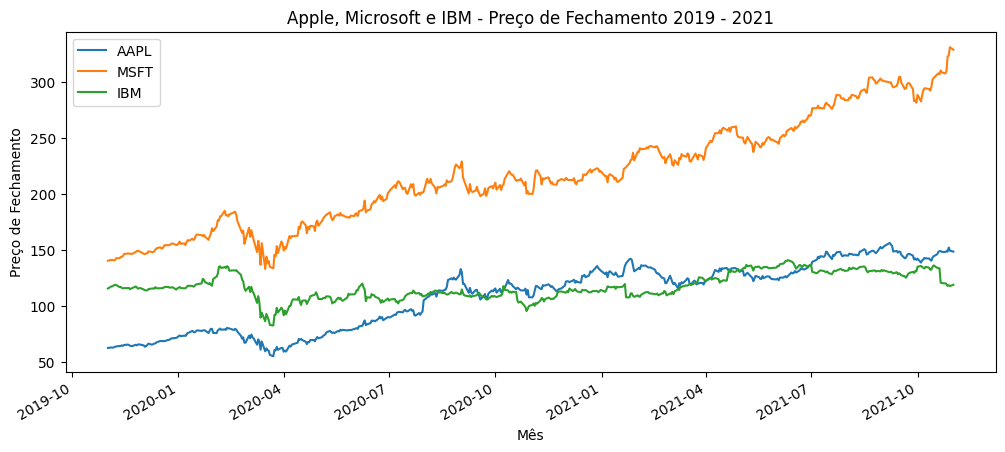

In [2]:
start_date = '2019'
end_date = '2021'
plot = closing_price.plot(title=f'Apple, Microsoft e IBM - Preço de Fechamento {start_date} - {end_date}',ylabel= 'Preço de Fechamento', xlabel='Mês')

Vou normalizar os dados dividindo os valores pelo primeiro valor de cada série. Vou também trocar o style:

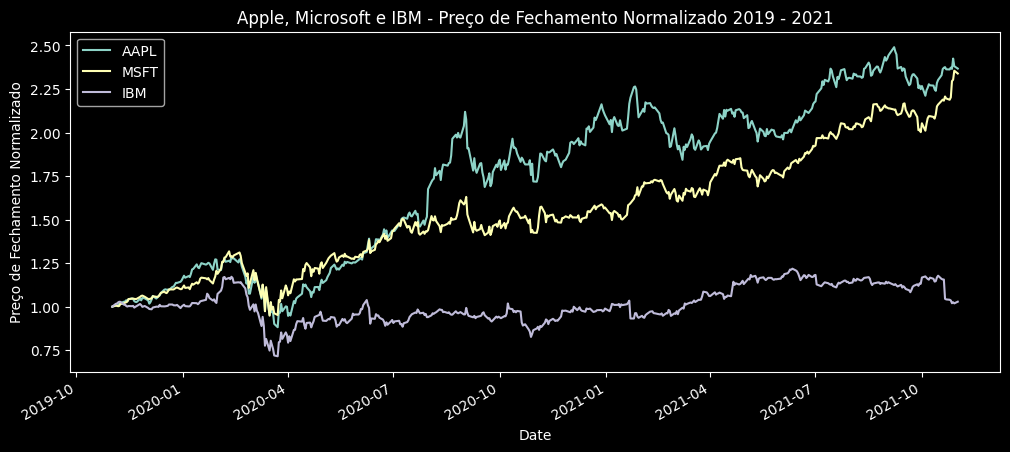

In [3]:
plt.style.use("dark_background")
closing_price_n = closing_price.div(closing_price.iloc[0])
plot = closing_price_n.plot(title=f'Apple, Microsoft e IBM - Preço de Fechamento Normalizado {start_date} - {end_date}',ylabel= 'Preço de Fechamento Normalizado')

Em séries temporais, o hvplot possibilita vermos a série de uma forma interativa:

In [4]:
closing_price_n.hvplot(title=f'Apple, Microsoft e IBM - Preço de Fechamento Normalizado {start_date} - {end_date}')

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [5]:
closing_price.hvplot(width=300, subplots=True)

:NdLayout   [Variable]
   :Curve   [Date]   (value)

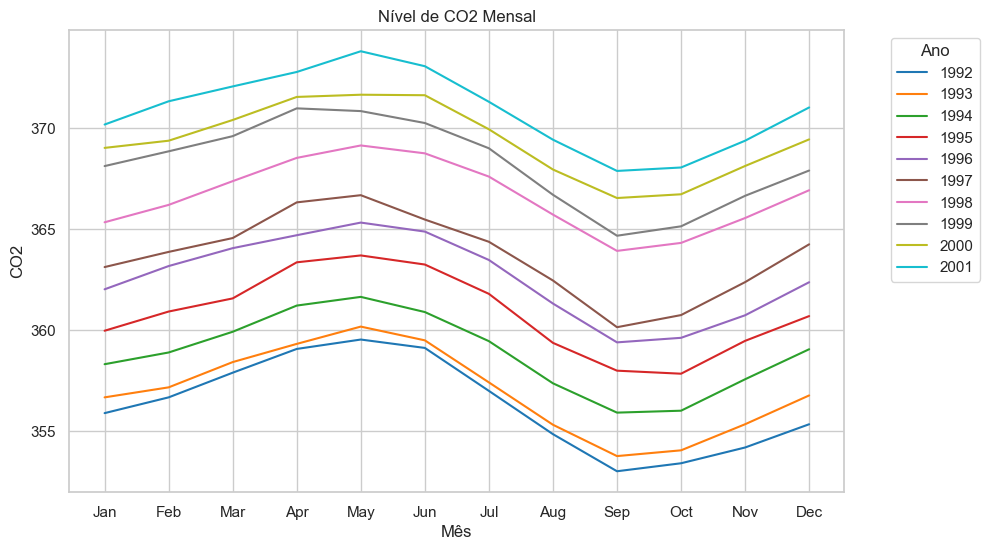

In [ ]:
co2_month = co2_df.resample('MS').mean()
co2_month = co2_month[co2_month.index.year > 1991]
co2_month['Year'] = co2_month.index.year
co2_month['Month'] = co2_month.index.month

# Reset index to use Seaborn
co2_month = co2_month.reset_index()

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=co2_month, x='Month', y='co2', hue='Year', palette='tab10')

plt.xlabel('Mês')
plt.ylabel('CO2')
plt.xticks(ticks=co2_month['Month'].unique(), labels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.title('Nível de CO2 Mensal')
plt.legend(title='Ano', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [36]:
co2_month

,index,co2,Year,Month,Month_rad
0,1992-01-01,355.900,1992,1,0.523599
1,1992-02-01,356.680,1992,2,1.047198
2,1992-03-01,357.900,1992,3,1.570796
3,1992-04-01,359.075,1992,4,2.094395
4,1992-05-01,359.540,1992,5,2.617994
...,...,...,...,...,...
115,2001-08-01,369.425,2001,8,4.188790
116,2001-09-01,367.880,2001,9,4.712389
117,2001-10-01,368.050,2001,10,5.235988
118,2001-11-01,369.375,2001,11,5.759587


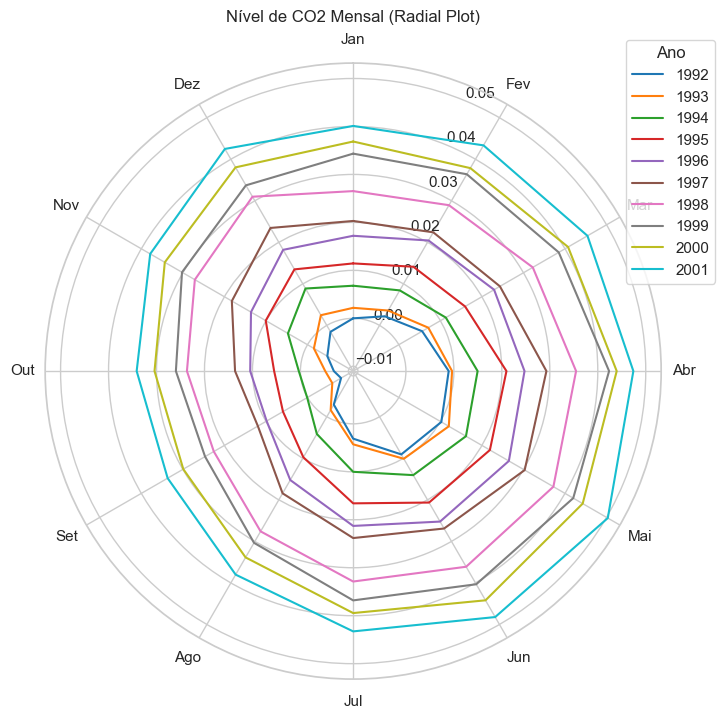

In [67]:
plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)

# Convert months to radians
co2_month['Month_rad'] = (co2_month['Month']-1) * (2 * np.pi / 12)
co2_month['co2_normalizado'] = (co2_month['co2']/co2_month['co2'][0])-1

# Plot each year as a separate line
years = co2_month['Year'].unique()
palette = sns.color_palette("tab10", len(years))
for i, year in enumerate(years):
    data = co2_month[co2_month['Year'] == year]
    # Ensure the data forms a continuous loop by appending the first month to the end
    data = pd.concat([data, data.iloc[[0]]])
    ax.plot(data['Month_rad'], data['co2_normalizado'], label=str(year), color=palette[i])

# Customize the plot
ax.set_theta_direction(-1)  # Clockwise
ax.set_theta_offset(np.pi / 2.0)  # Start at January (top)
ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
ax.set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
ax.set_title('Nível de CO2 Mensal (Radial Plot)', va='bottom')
plt.legend(title='Ano', bbox_to_anchor=(1.1, 1.05))

plt.show()

# Decomposição de uma série:
- Uma série temporal pode ser dividida em 3 grandes componentes
    - Tendência
    - Sazonalidade
    - Resíduo
- Tendência: Padrão de longo prazo (crescimento, queda, etc...)
- Sazonalidade: Comportamento que se repete de tempo em tempo.
- Resíduo: Como falamos em Santos, a reba. O que sobra na mesa que não foi explicado pela tendência e sazonalidade.

- Decomposição de uma série é o processo de extrair esses componentes, alguns métodos focam em extrair a tendência dos dados, outros isolam a sazonalidade. Ainda vamos ver métodos que extraem os dois componentes (tendência e sazonalidade)


Métodos:

- Hodrick-Prescott: Extrai a Tendência dos dados 
    - hp_filter
- Seasonal-Trend LOESS (Locally Estimated Sacatterplot Smoothing)
    - seasonal_decompose (Aditivo e Multiplicativo)
    - STL (Opção robusta porém assume relacionamento aditivo)
- Gráficos de sazonalidade.


podemos assumir que esses componentes interagem de forma aditiva ou multiplicativa:

- Aditiva: O valor incremental devido a sazonalidade é constante. Exemplo: Todo dezembro o consume de energia em uma região aumenta 500 MWh por causa das luzes de natal (+500)
    
- Multiplicativo: O valor incremental devido a sazonalidade depende também do atual nível da série. Exemplo: As vendas durante a semana do black friday crescem  20% (x 1.2).

### Passos STL:
- Remoção da tendência (Detrending)
    - Ajusta um suavizador LOESS à série temporal para estimar a tendência.
    - Subtrai a tendência estimada dos dados originais para obter a série detrendida.
- Extração da componente sazonal
    - Agrupa os valores por período sazonal (ex: todos os janeiros, todos os fevereiros).
    - Aplica LOESS separadamente a cada grupo sazonal para suavizar a variação.
    - Ajusta a sazonalidade para ter média zero ao longo de um ciclo completo.
- Refinamento da tendência
    - Subtrai a sazonalidade dos dados para obter uma série sem efeitos sazonais.
    - Aplica LOESS novamente para refinar a tendência.
- Cálculo dos resíduos
    - Subtrai as componentes tendência + sazonalidade dos dados originais.

- Iteração até convergência
    - Repete os passos até que os componentes se estabilizem.

### Passos LOESS:
Selecionar um Intervalo: Escolha um intervalo (ou largura de banda) que determina a proporção de pontos de dados usados para cada regressão local.

Ponderação: Para cada ponto no conjunto de dados, atribua pesos aos pontos próximos com base na sua distância. Pontos mais próximos recebem pesos maiores.

Regressão Local: Ajuste uma regressão dos mínimos quadrados ponderados dentro do intervalo para cada ponto. Esta regressão é tipicamente linear ou quadrática.

Previsão: Use a regressão local ajustada para prever o valor suavizado para cada ponto.

Combinar: Combine todas as regressões locais para formar uma curva suave sobre todo o conjunto de dados.



In [6]:
import pandas as pd
import statsmodels as sm
from statsmodels.datasets import elec_equip, co2
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import matplotlib.pyplot as plt

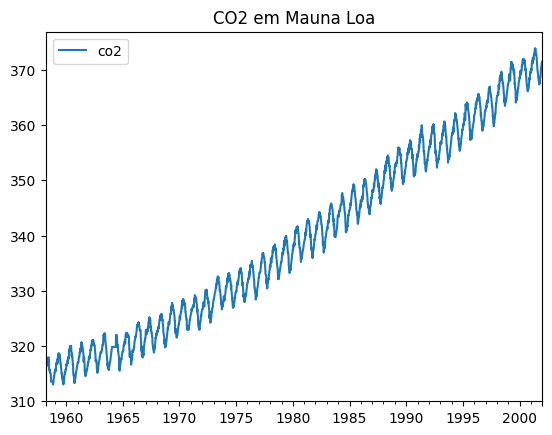

In [7]:
plt.style.use('default')
plpt = co2_df.plot(title='CO2 em Mauna Loa')

In [ ]:
co2_df.resample()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


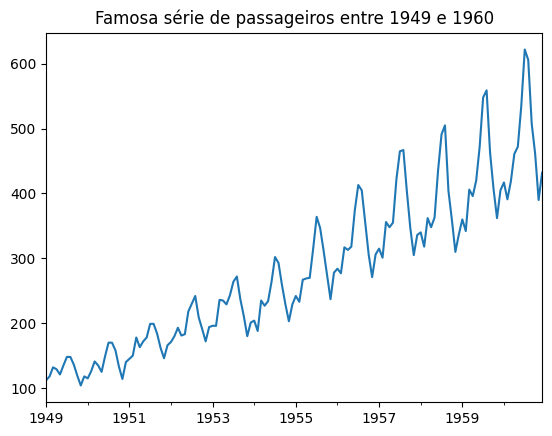

In [8]:
plot = airp_df['value'].plot(title='Famosa série de passageiros entre 1949 e 1960')

Cheeta morreu em 2022. nasceu em 1932 ou 1960?

In [9]:
co2_decomposed = seasonal_decompose(co2_df,model='additive')
air_decomposed = seasonal_decompose(airp_df,model='multiplicative')

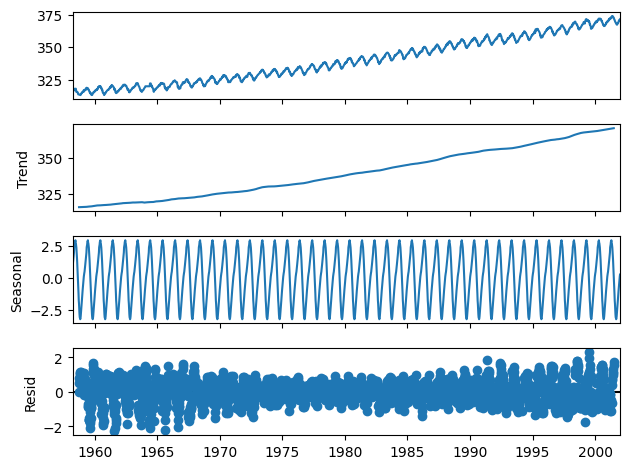

In [10]:
plot = co2_decomposed.plot()

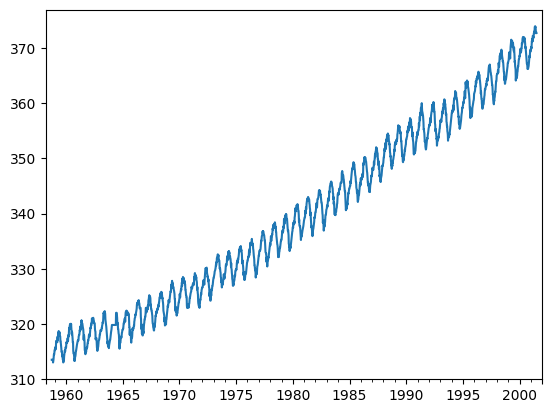

In [11]:
plot = (co2_decomposed.trend + 
     co2_decomposed.seasonal + 
     co2_decomposed.resid).plot()

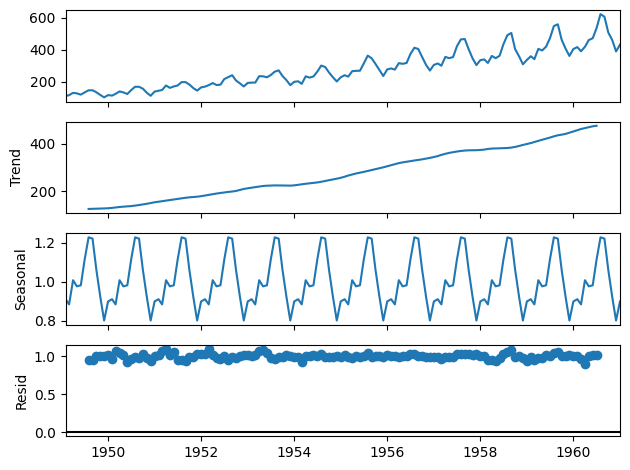

In [12]:
plot = air_decomposed.plot()

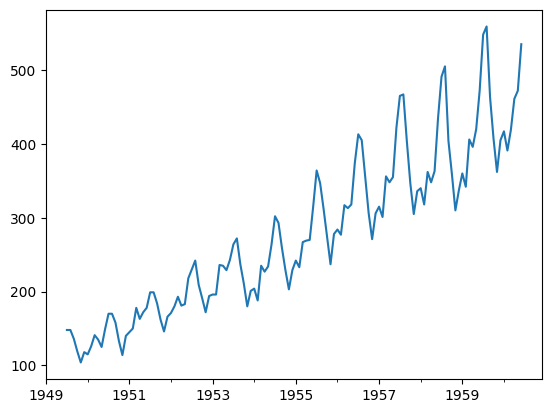

In [13]:
plot = (air_decomposed.trend * 
     air_decomposed.seasonal * 
     air_decomposed.resid).plot()

STL (Seasonal-Trend decomposition using LOESS) é uma implementação do statsmodel que contém uma opção bem interessante (robust=True) para não deixar outliers influenciarem tanto, porém ele sempre assume um relacionamento aditivo entre os componentes.  

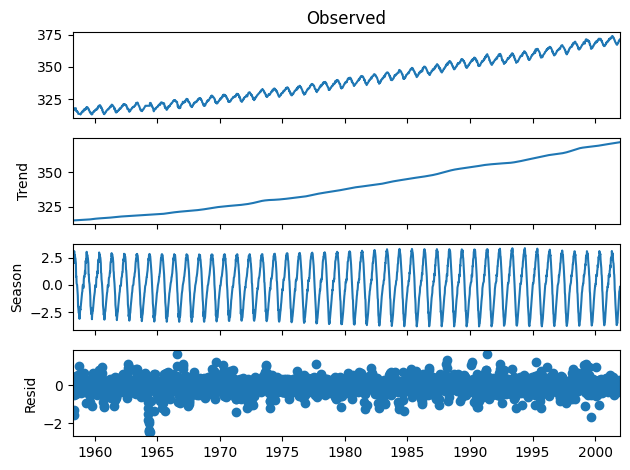

In [14]:
co2_stl = STL(
    co2_df, 
    seasonal=13, 
    robust=True).fit()
plot = co2_stl.plot()

### Hodrick - Prescott Filter

Objetivo: Minimizar o desvio quadrático dos dados e o componente de tendência, ao mesmo tempo que se minimiza o desvio quadrático da segunda diferença do mesmo componente de tendência (para evitar curvaturas excessivas)

$ y_t $ : Dado observado no período t.

$ \tau_t $ : Componente de tendência no período t.

$ c_t $ : Componente cíclico

$ y_t = c_t + \tau_t $ 

O filtro de Hodrick - Prescott resolve o seguinte problema de otimização:

$$ 
\min_{\tau_t} \left( \sum_{t=1}^{T} (y_t - \tau_t)^2 + \lambda \sum_{t=2}^{T-1} ((\tau_{t+1} - \tau_t) - (\tau_t - \tau_{t-1}))^2 \right) 
$$

O primeiro termo $ \sum_{t=1}^{T} (y_t - \tau_t)^2 $ garante que o componente de tendência fique perto dos dados observados.

The segundo termo $ \sum_{t=2}^{T-1} ((\tau_{t+1} - \tau_t) - (\tau_t - \tau_{t-1}))^2 $ garante que o componente de tendência seja suave.

(\lambda) é o parâmetro de suavização e controla o trade-off entre ajuste aos dados e suavização. $ \lambda $ grande aumenta a suavidade do componente de tendência. 

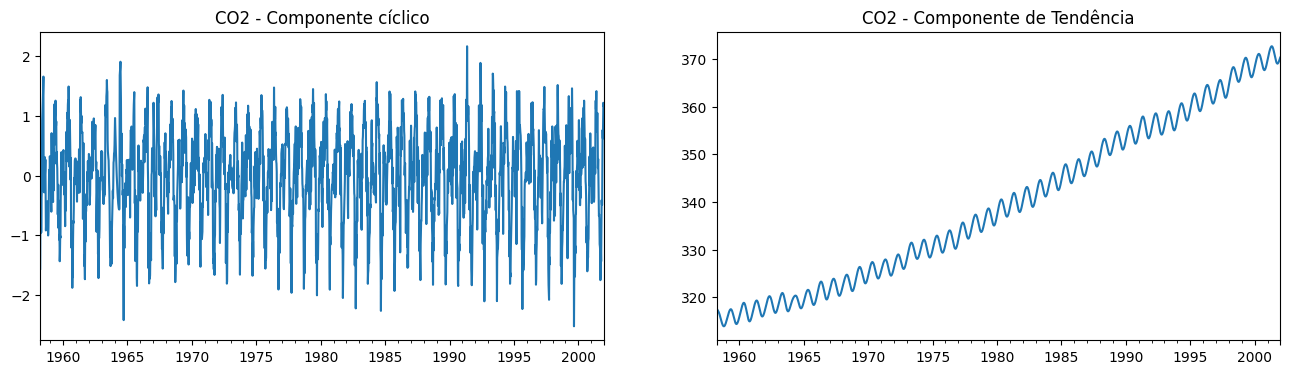

In [15]:
from statsmodels.tsa.filters.hp_filter import hpfilter
co2_cyclic, co2_trend = hpfilter(co2_df)
fig, ax = plt.subplots(1,2, figsize=(16, 4))
co2_cyclic.plot(ax=ax[0], title='CO2 - Componente cíclico')
co2_trend.plot(ax=ax[1], title='CO2 - Componente de Tendência')
plt.show()


Regras de bolso para o lambda:

Anual: $ \lambda \approx 100 $ 

Trimestral (Quarter): $ \lambda \approx 1600 $ 

Mensal: $ \lambda \approx 14400 $

Semanal: $ \lambda \approx 270400 $

Se vocês não gostam de regras de bolso, vocês podem se aproxundar nesse artigo: https://home.uchicago.edu/~huhlig/papers/uhlig.ravn.res.2002.pdf

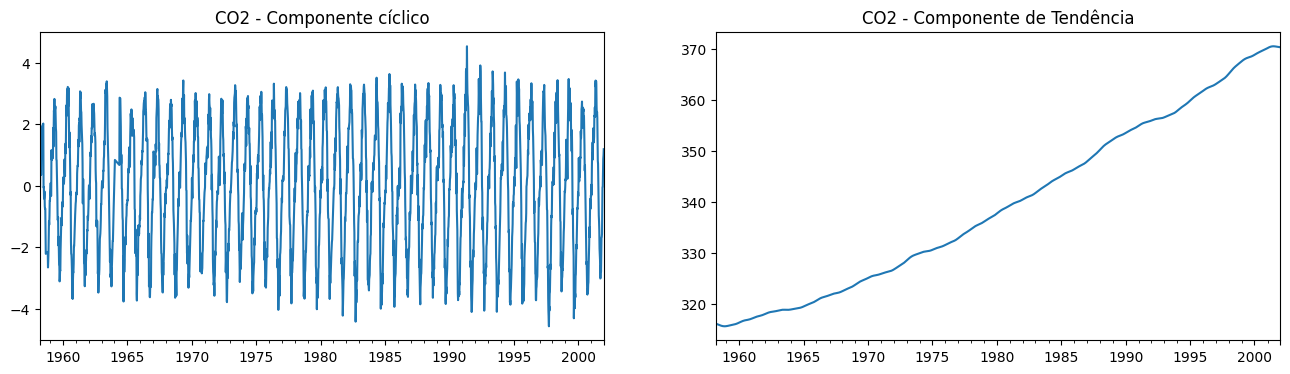

In [16]:
lamb = 270400
co2_cyclic, co2_trend = hpfilter(co2_df, lamb=lamb)
fig, ax = plt.subplots(1,2, figsize=(16, 4))
co2_cyclic.plot(ax=ax[0], title='CO2 - Componente cíclico')
co2_trend.plot(ax=ax[1], title='CO2 - Componente de Tendência')
plt.show()

# Estacionariedade

Um dos conceitos mais discutidos e super simplificados da Estatística. Estacionariedade estrita é quando todas as propriedades estatísticas de uma série não mudam com o tempo. 

Uma série temporal $X_t$ é estritamente estacionária se a distribuição conjunta de:

$
(X_{t_1}, X_{t_2}, \dots, X_{t_n})
$ 

for a mesma que:

$
(X_{t_1+h}, X_{t_2+h}, \dots, X_{t_n+h})
$ 

para todos os tempos $t_1, t_2, \dots, t_n$ e qualquer defasagem $h$.

Existem testes para verificar a validade de uma estacionariedade estrita, porém é muito difícil encontrar problemas reais que sigam essa suposição.

O conceito de estacionariedade fraca ganhou força recentemente https://www.youtube.com/watch?v=sqZtT6o6B6U.

Uma série temporal $X_t$ é fracamente estacionária se satisfizer as seguintes condições:

- **Média Constante**:  
  $
  E[X_t] = \mu
  $
  independente de $t$.

- **Variância Constante**:  
  $
  \text{Var}(X_t) = \sigma^2
  $
  independente de $t$.

- **Autocovariância depende apenas do defasagem (lag)**:  
  $
  \text{Cov}(X_t, X_{t+h})
  $
  depende apenas do lag $h$, e não do tempo $t$ específico.

https://www.youtube.com/watch?v=beHFZa-t89A
